## Module 4:

## Team Members:
Mary Burns & William Collins

## Project Title:
SIR-Based Epidemiological Analysis of Ebola Epidemic



## Project Goal:
This project seeks to use the epidemiological SIR model to understand how Ebola spread during the 2014 outbreak in Sierra Leone. Through the analysis of real infection data, the implementation of numerical ODE methods, and the fitting of the SIR system to observed cases, we aim to understand how epidemiological parameters can shape disease dynamics and evaluate the accuracy of numerical solutions in situations where analytic solutions are not an option.

## Disease Background:

* Prevalence & incidence
    - In a global sense, Ebola is a rare disease. This means prevalence at baseline is typically low; however, during an outbreak (such as Sierra Leone, 2014), incidence rapidly increases since this disease spreads through direct contact with bodily fluids of symptomatic individuals. As new infections occur, prevalence spikes, but reamins limited to specific communities (due to the short infectious period & high fatality rate). Since many patients that experience this disease either recover or die within a short timeframe, prevalnce is observed to sharply fluctuate rather than remain in a sustained state.
    - https://www.who.int/news-room/fact-sheets/detail/ebola-disease
* Economic burden
    - Ebola poses an extensive economic burden. For example, the 2014 Sierra Leone outbreak was estimated to cost between US$ 30-50 billion. The most prominent cost driver was the creation or modification of healthcare facilties to ensure preparedness. 
    - https://pubmed.ncbi.nlm.nih.gov/38299454/
* Risk factors (genetic, lifestyle) & Societal determinants
    - Lifestyle risk factors include caregiving for a symptomatic patient withough proper protective equipment and the participation in traditional burial practices. Genetic risk factors are less common, but immune variation of individuals can influence susceptibility and disease severity.
    - Societal determinants include limited healthcare access/infrastructure, poverty, overpopulated living conditons, or delayed access to treatment. 
    - https://pmc.ncbi.nlm.nih.gov/articles/PMC6880008/
* Symptoms
    - Symptoms of Ebola include: fever, fatigue, myalgia, sore throat, emesis, diarrhea, abdominal pain, and impaired kidney and/or liver function. Other less common symptoms include: internal bleeding, external bleeding, confusion, irritability, aggression, or other CNS effects. 
    - https://www.who.int/news-room/fact-sheets/detail/ebola-disease
* Diagnosis
    - To confirm an Ebola diagnoses, extensive and specialized laboratory testing is required. The "gold standard" of diagnosing Ebola is through RT-PCR, which detects viral RNA. Other diagnostic measures can include: antibody-capture ELISA, antigen-detection assays, and viral isolation in cell culture. 
    - https://www.who.int/news-room/fact-sheets/detail/ebola-disease
* Biological mechanisms (anatomy, organ physiology, cell & molecular physiology)
    - Ebola targets multiple rogan systems. Initially, it infects endothelal cells, hepatocytes, and antigen-presenting cells which leads to widespread vascular dysfunction, liver/kidney failure, then multiorgan collapse. Ebola enters cells through macropinocytosis, suppresses interferon-driven antiviral responses, hijakcs host transcription and translation, and triggers a severe inflammatory cytokine storm. This results in widespread apoptosis which drives the disease's intense progression and endoreses its high mortality rate.
    - https://pmc.ncbi.nlm.nih.gov/articles/PMC4495366/

## Dataset: 

### Dataset Description
Our dataset contains daily confirmed Ebola cases from the 2014 outbreak in Sierra Leone, which was provided through a cleaned two-column CSV on Canvas. The data was originally collected through national case surveillance, which included confirmed diagnoses reported to public health authorities. Since datasets often include cumulative cases, the time series was converted to incident infections per day using differencing and smoothed using a moving average consistent with the provided convert_cumulative_to_SIR function. All case counts are measured in a number of confirmed cases per day and dates are recorded in calendar days corresponding to the progression of the outbreak. 

In [10]:
## LOAD YOUR DATASET HERE.

# 1. Read in the csv file of cumulative cases.

# 2. Use the convert_cumulative_to_SIR function to convert cumulative cases to approximate S, I, R at any given time.

# 3. Plot S, I, R over time.

In [11]:
import numpy as np, pandas as pd
from datetime import datetime, timedelta

# Ebola numbers — Sierra Leone 2014–2015
# Approx population (can tweak if you want)
N = 6.2e6 # people

# Read your cumulative Ebola data
df_full = pd.read_csv("ebola_sierra_leone_data_2014_2015_cumulative.csv")

# Make sure date is a datetime
df_full["date"] = pd.to_datetime(df_full["date"])

# Sort just in case
df_full = df_full.sort_values("date")

# Convert cumulative confirmed_cases -> new cases per day (I_obs)
df_full["I_obs"] = df_full["confirmed_cases"].diff()

# For the first row, diff() is NaN, so just use the first cumulative value
first_idx = df_full.index[0]
df_full.loc[first_idx, "I_obs"] = df_full.loc[first_idx, "confirmed_cases"]

# Optionally, you can drop any trailing rows where nothing changes
# (this is when the outbreak has basically ended)
# df_full = df_full[df_full["I_obs"] > 0]

df_full.head()

,date,confirmed_cases,I_obs
0,2014-08-29,1026.0,1026.0
1,2014-09-05,1261.0,235.0
2,2014-09-08,1361.0,100.0
3,2014-09-12,1424.0,63.0
4,2014-09-16,1620.0,196.0


This code will create a graph of all the data we have of new confirmed cases per day during the ebola outbreak 2014-2015

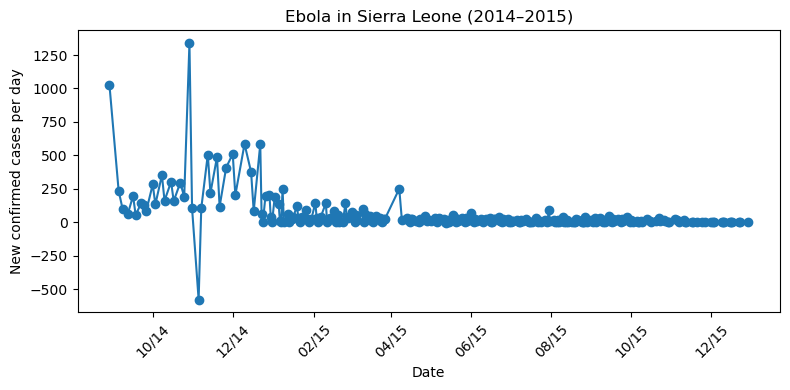

In [12]:
# Quick exploration plot of Ebola data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(8,4))
plt.plot(df_full["date"], df_full["I_obs"], "o-")
plt.xlabel("Date")
plt.ylabel("New confirmed cases per day")
plt.title("Ebola in Sierra Leone (2014–2015)")

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%y"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
N = 6.2e6

This code will load in our Euler function 

In [14]:
# ----------------------------------------------------------
# Euler integrator function for the SIR Model
# ----------------------------------------------------------

import numpy as np

def euler_sir(beta, gamma, S0, I0, R0, t_obs, N):
    """
    Runs the SIR model using Euler's method.
    """

    dt = t_obs[1] - t_obs[0] # timestep size

    S = np.zeros(len(t_obs))
    I = np.zeros(len(t_obs))
    R = np.zeros(len(t_obs))

    # Initial conditions
    S[0] = S0
    I[0] = I0
    R[0] = R0

    # Euler update loop
    for k in range(len(t_obs)-1):

        dS = -(beta / N) * S[k] * I[k]
        dI = (beta / N) * S[k] * I[k] - gamma * I[k]
        dR = gamma * I[k]

        S[k+1] = S[k] + dS * dt
        I[k+1] = I[k] + dI * dt
        R[k+1] = R[k] + dR * dt

    return S, I, R

print("Euler SIR function loaded!")

Euler SIR function loaded!


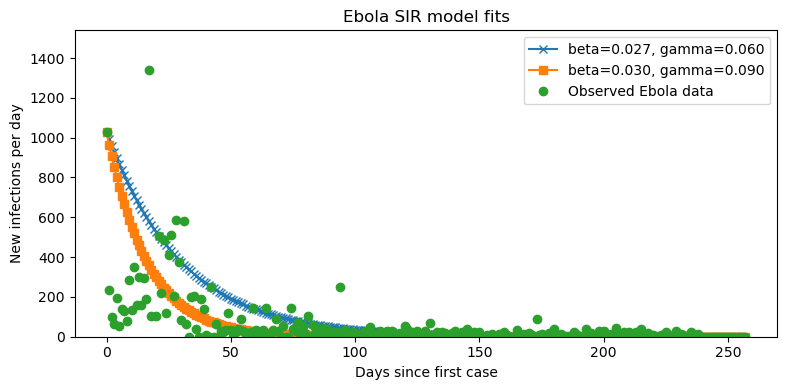

SSE guess 1: 39265.75217589732
SSE guess 2: 26961.816945556006


In [15]:
# ------------------------------------
# Run Euler's Method on Ebola dataset
# ------------------------------------

# Use your Ebola I_obs and time array t_obs
I_obs = df_full["I_obs"].values.astype(float)
t_obs = np.linspace(0, len(I_obs)-1, len(I_obs))

# Initial values
I0_obs = I_obs[0]
R0_obs = 0.0
S0_obs = N - I0_obs - R0_obs

# Pick two beta/gamma guesses
beta1 = 0.027
gamma1 = 0.06

beta2 = 0.03
gamma2 = 0.09

# Run SIR with Euler's method
S1, I1, R1 = euler_sir(beta1, gamma1, S0_obs, I0_obs, R0_obs, t_obs, N)
S2, I2, R2 = euler_sir(beta2, gamma2, S0_obs, I0_obs, R0_obs, t_obs, N)

# Plot
plt.figure(figsize=(8,4))
plt.plot(t_obs, I1, label=f"beta={beta1:.3f}, gamma={gamma1:.3f}", marker='x')
plt.plot(t_obs, I2, label=f"beta={beta2:.3f}, gamma={gamma2:.3f}", marker='s')
plt.plot(t_obs, I_obs, "o", label="Observed Ebola data")

plt.legend()
plt.xlabel("Days since first case")
plt.ylabel("New infections per day")
plt.title("Ebola SIR model fits")
plt.tight_layout()
plt.ylim(0, min(np.max(I1), np.max(I2))*1.5)
plt.show()

print("SSE guess 1:", np.mean((I1 - I_obs)**2))
print("SSE guess 2:", np.mean((I2 - I_obs)**2))

In [16]:
# ----------------------------------------------------------
# Euler's Method for the SIR Model
# ----------------------------------------------------------

import numpy as np

def euler_sir(beta, gamma, S0, I0, R0, t_obs, N):
    """
    Runs the SIR model using Euler's method.

    Parameters:
        beta = infection rate parameter
        gamma = recovery rate parameter
        S0, I0, R0 = initial conditions
        t_obs = numpy array of time points (e.g., 0,1,2,...)
        N = total population
    """
    dt = t_obs[1] - t_obs[0] # timestep size
    S = np.zeros(len(t_obs))
    I = np.zeros(len(t_obs))
    R = np.zeros(len(t_obs))

    # initial conditions
    S[0] = S0
    I[0] = I0
    R[0] = R0

    for k in range(len(t_obs)-1):
        dS = -(beta / N) * S[k] * I[k]
        dI = (beta / N) * S[k] * I[k] - gamma * I[k]
        dR = gamma * I[k]

        S[k+1] = S[k] + dS * dt
        I[k+1] = I[k] + dI * dt
        R[k+1] = R[k] + dR * dt

    return S, I, R

print("Euler SIR function loaded.")


Euler SIR function loaded.


This code uses an Euler SIR solver to compare two beta–gamma parameter sets against observed infection data by plotting their trajectories and computing SSE.


This code performs a grid search over beta and gamma using an Euler SIR model to find the parameter pair that best fits observed daily new infections and then plots the optimal fit.


Best beta: 0.06
Best gamma: 0.0649367088607595
Best SSE (incidence fit): 5094285.145687886


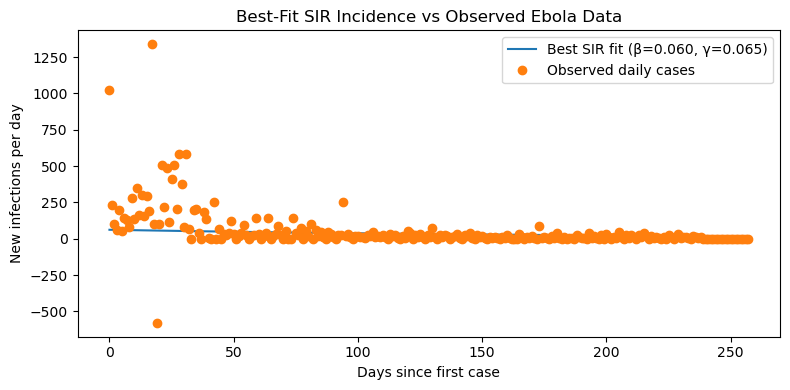

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------
# GRID SEARCH: fit daily new infections
# ------------------------------------

# Search ranges
beta_vals  = np.linspace(0.005, 0.06, 80)
gamma_vals = np.linspace(0.03, 0.15, 80)

best_error = np.inf
best_beta = None
best_gamma = None
best_new_cases = None

dt = t_obs[1] - t_obs[0]   # should be 1.0 in your setup

for beta in beta_vals:
    for gamma in gamma_vals:
        # Run SIR model with Euler
        S_tmp, I_tmp, R_tmp = euler_sir(beta, gamma, S0_obs, I0_obs, R0_obs, t_obs, N)
        
        # Convert SIR state to *daily new infections*
        new_cases_model = (beta * S_tmp * I_tmp / N) * dt   # incidence
        
        # Compute SSE between model incidence and observed daily cases
        error = np.sum((new_cases_model - I_obs)**2)
        
        if error < best_error:
            best_error = error
            best_beta = beta
            best_gamma = gamma
            best_new_cases = new_cases_model.copy()

print("Best beta:", best_beta)
print("Best gamma:", best_gamma)
print("Best SSE (incidence fit):", best_error)

# ------------------------------------
# Plot best-fit daily new infections
# ------------------------------------

plt.figure(figsize=(8,4))
plt.plot(t_obs, best_new_cases, label=f"Best SIR fit (β={best_beta:.3f}, γ={best_gamma:.3f})")
plt.plot(t_obs, I_obs, "o", label="Observed daily cases")

plt.xlabel("Days since first case")
plt.ylabel("New infections per day")
plt.title("Best-Fit SIR Incidence vs Observed Ebola Data")
plt.legend()
plt.margins(y=0.05)
plt.tight_layout()
plt.show()

This code uses a Runge–Kutta SIR solver (solve_ivp) to grid-search beta and gamma values that best fit the observed outbreak data and then plots the optimal model prediction.



---- RK4 OPTIMIZATION RESULTS ----
Best RK4 beta: 0.06
Best RK4 gamma: 0.0649367088607595
Best RK4 SSE: 5094351.219611119


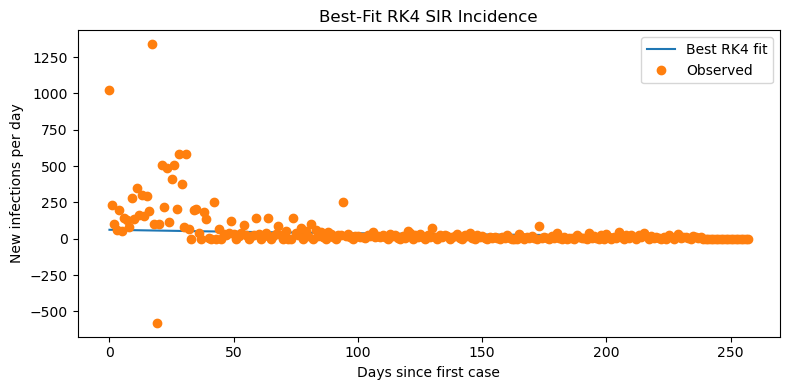

In [18]:
# -------------------------------------------------------
# RK4 (Runge-Kutta 4th order) SIR function using solve_ivp
# -------------------------------------------------------
from scipy.integrate import solve_ivp

def sir_deriv(t, y, beta, gamma, N):
    S, I, R = y
    dS = -(beta / N) * S * I
    dI =  (beta / N) * S * I - gamma * I
    dR =  gamma * I
    return [dS, dI, dR]

def rk4_sir(beta, gamma, S0, I0, R0, t_obs, N):
    y0 = [S0, I0, R0]

    sol = solve_ivp(
        fun=lambda t, y: sir_deriv(t, y, beta, gamma, N),
        t_span=(t_obs[0], t_obs[-1]),
        y0=y0,
        t_eval=t_obs,
        method='RK45'
    )

    S, I, R = sol.y
    return S, I, R


# -------------------------------------------------------
# GRID SEARCH using RK4 (solve_ivp)
# -------------------------------------------------------

best_error_rk = np.inf
best_beta_rk = None
best_gamma_rk = None
best_new_cases_rk = None

dt = t_obs[1] - t_obs[0]

for beta in beta_vals:
    for gamma in gamma_vals:

        S_rk, I_rk, R_rk = rk4_sir(beta, gamma, S0_obs, I0_obs, R0_obs, t_obs, N)
        new_cases_rk = (beta * S_rk * I_rk / N) * dt

        error_rk = np.sum((new_cases_rk - I_obs)**2)

        if error_rk < best_error_rk:
            best_error_rk = error_rk
            best_beta_rk = beta
            best_gamma_rk = gamma
            best_new_cases_rk = new_cases_rk.copy()

print("\n---- RK4 OPTIMIZATION RESULTS ----")
print("Best RK4 beta:", best_beta_rk)
print("Best RK4 gamma:", best_gamma_rk)
print("Best RK4 SSE:", best_error_rk)

# Plot
plt.figure(figsize=(8,4))
plt.plot(t_obs, best_new_cases_rk, label="Best RK4 fit")
plt.plot(t_obs, I_obs, "o", label="Observed")
plt.legend()
plt.xlabel("Days since first case")
plt.ylabel("New infections per day")
plt.title("Best-Fit RK4 SIR Incidence")
plt.tight_layout()
plt.show()

This code fits beta and gamma using the first half of the data with an Euler SIR model, then uses those parameters to predict the second half and compare against observed cases.


---- TRAINING RESULTS (using first half only) ----
Best beta: 0.06
Best gamma: 0.06189873417721519
Training SSE: 5032380.223891177

---- TEST (Prediction) RESULTS ----
Test SSE (second half): 150781.58790393185


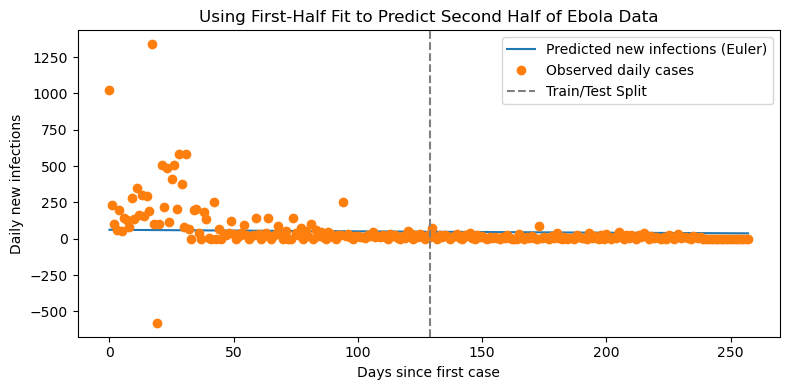

In [19]:
# -------------------------------------------------------
# Fit the first half of the data using Euler
# -------------------------------------------------------

mid = len(t_obs) // 2

# First-half training data
t_train = t_obs[:mid]
I_train = I_obs[:mid]

# Reset best trackers
best_error = np.inf
best_beta = None
best_gamma = None
best_new_cases = None

dt = t_train[1] - t_train[0]

for beta in beta_vals:
    for gamma in gamma_vals:

        # Run Euler SIR on FIRST HALF only
        S_tmp, I_tmp, R_tmp = euler_sir(beta, gamma,
                                        S0_obs, I0_obs, R0_obs,
                                        t_train, N)

        # Convert SIR → daily new infections for training
        new_cases_model = (beta * S_tmp * I_tmp / N) * dt

        # SSE against FIRST HALF
        error = np.sum((new_cases_model - I_train)**2)

        if error < best_error:
            best_error = error
            best_beta = beta
            best_gamma = gamma
            best_new_cases = new_cases_model.copy()

print("\n---- TRAINING RESULTS (using first half only) ----")
print("Best beta:", best_beta)
print("Best gamma:", best_gamma)
print("Training SSE:", best_error)

# -------------------------------------------------------
# Predict the FUTURE (second half) using best parameters
# -------------------------------------------------------

# Simulate with Euler across the FULL time domain
S_full, I_full, R_full = euler_sir(best_beta, best_gamma,
                                   S0_obs, I0_obs, R0_obs,
                                   t_obs, N)

# Convert to daily new infections
dt_full = t_obs[1] - t_obs[0]
new_cases_full = (best_beta * S_full * I_full / N) * dt_full

# Compute SSE on the second half
I_test = I_obs[mid:]
pred_test = new_cases_full[mid:]
SSE_test = np.sum((pred_test - I_test)**2)

print("\n---- TEST (Prediction) RESULTS ----")
print("Test SSE (second half):", SSE_test)

# plot predivtion vs observed
plt.figure(figsize=(8,4))
plt.plot(t_obs, new_cases_full, label="Predicted new infections (Euler)")
plt.plot(t_obs, I_obs, "o", label="Observed daily cases")

plt.axvline(t_obs[mid], color='gray', linestyle='--', label="Train/Test Split")

plt.xlabel("Days since first case")
plt.ylabel("Daily new infections")
plt.title("Using First-Half Fit to Predict Second Half of Ebola Data")
plt.legend()
plt.tight_layout()
plt.show()


This code solves the SIR epidemic model using Runge–Kutta methods and compares two parameter sets to observed infection data by plotting results and computing SSE.

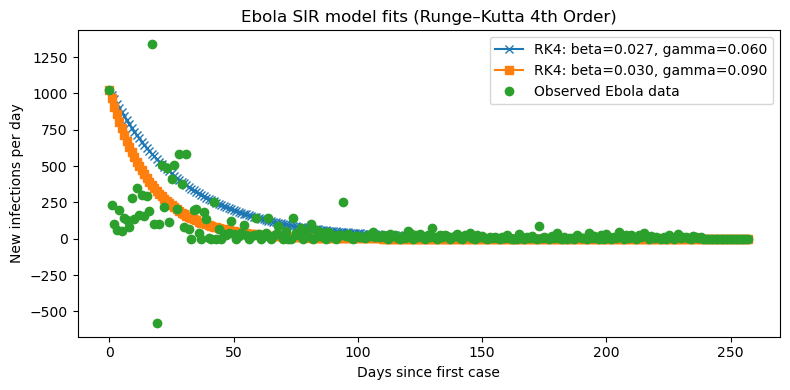

RK4 SSE guess 1: 39841.753976760054
RK4 SSE guess 2: 27272.672097321603


In [20]:
from scipy.integrate import solve_ivp

def sir_deriv(t, y, beta, gamma, N):
    S, I, R = y
    dS = -(beta / N) * S * I
    dI =  (beta / N) * S * I - gamma * I
    dR =  gamma * I
    return [dS, dI, dR]

def rk4_sir(beta, gamma, S0, I0, R0, t_obs, N):
    y0 = [S0, I0, R0]

    sol = solve_ivp(
        fun=lambda t, y: sir_deriv(t, y, beta, gamma, N),
        t_span=(t_obs[0], t_obs[-1]),
        y0=y0,
        t_eval=t_obs,         
        method='RK45'         
    )
    
    S, I, R = sol.y
    return S, I, R

S1_rk, I1_rk, R1_rk = rk4_sir(beta1, gamma1, S0_obs, I0_obs, R0_obs, t_obs, N)
S2_rk, I2_rk, R2_rk = rk4_sir(beta2, gamma2, S0_obs, I0_obs, R0_obs, t_obs, N)

plt.figure(figsize=(8,4))
plt.plot(t_obs, I1_rk, label=f"RK4: beta={beta1:.3f}, gamma={gamma1:.3f}", marker='x')
plt.plot(t_obs, I2_rk, label=f"RK4: beta={beta2:.3f}, gamma={gamma2:.3f}", marker='s')
plt.plot(t_obs, I_obs, "o", label="Observed Ebola data")

plt.xlabel("Days since first case")
plt.ylabel("New infections per day")
plt.title("Ebola SIR model fits (Runge–Kutta 4th Order)")
plt.legend()
plt.margins(y=0.05)
plt.tight_layout()
plt.show()

print("RK4 SSE guess 1:", np.mean((I1_rk - I_obs)**2))
print("RK4 SSE guess 2:", np.mean((I2_rk - I_obs)**2))


In [22]:
# -----------------------------
# Train/test split: first half vs second half
# -----------------------------
n = len(I_obs)
mid = n // 2

t_train = t_obs[:mid]
I_train = I_obs[:mid]

t_test = t_obs[mid:]
I_test = I_obs[mid:]

dt_train = t_train[1] - t_train[0]
dt_full  = t_obs[1] - t_obs[0]

print("n =", n, "mid =", mid)


n = 258 mid = 129


In [23]:
# -----------------------------
# Euler: fit beta/gamma on FIRST HALF (grid search), using incidence SSE
# -----------------------------
best_err_euler_train = np.inf
best_beta_euler_train = None
best_gamma_euler_train = None

for beta in beta_vals:
    for gamma in gamma_vals:
        S_tmp, I_tmp, R_tmp = euler_sir(beta, gamma, S0_obs, I0_obs, R0_obs, t_train, N)
        inc_tmp = (beta * S_tmp * I_tmp / N) * dt_train
        err = np.sum((inc_tmp - I_train)**2)
        if err < best_err_euler_train:
            best_err_euler_train = err
            best_beta_euler_train = beta
            best_gamma_euler_train = gamma

print("Euler first-half best beta:", best_beta_euler_train)
print("Euler first-half best gamma:", best_gamma_euler_train)
print("Euler SSE on FIRST HALF (train):", best_err_euler_train)

# -----------------------------
# Euler: predict FULL timeline using first-half fit
# -----------------------------
S_pred, I_pred, R_pred = euler_sir(best_beta_euler_train, best_gamma_euler_train,
                                  S0_obs, I0_obs, R0_obs, t_obs, N)
inc_pred_full_euler = (best_beta_euler_train * S_pred * I_pred / N) * dt_full

# SSE on SECOND HALF only
sse_euler_second_half = np.sum((inc_pred_full_euler[mid:] - I_test)**2)
print("Euler SSE on SECOND HALF (test):", sse_euler_second_half)


Euler first-half best beta: 0.06
Euler first-half best gamma: 0.06189873417721519
Euler SSE on FIRST HALF (train): 5032380.223891177
Euler SSE on SECOND HALF (test): 150781.58790393185


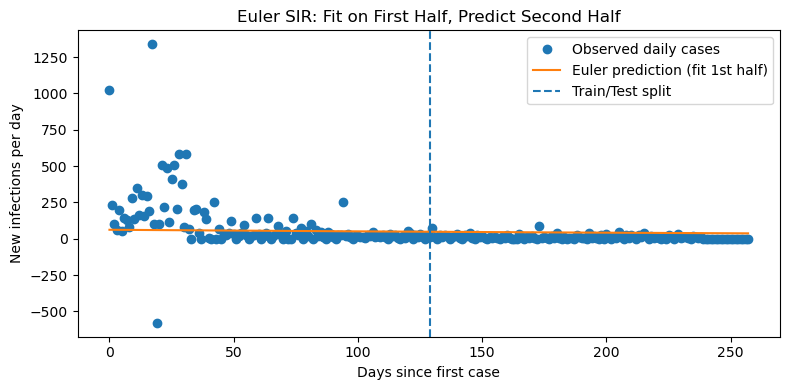

In [24]:
plt.figure(figsize=(8,4))
plt.plot(t_obs, I_obs, "o", label="Observed daily cases")
plt.plot(t_obs, inc_pred_full_euler, label="Euler prediction (fit 1st half)")
plt.axvline(t_obs[mid], linestyle="--", label="Train/Test split")
plt.xlabel("Days since first case")
plt.ylabel("New infections per day")
plt.title("Euler SIR: Fit on First Half, Predict Second Half")
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
print("Parameter comparison:")
print("Full-data fit:      beta =", best_beta, "gamma =", best_gamma)
print("First-half-only fit beta =", best_beta_euler_train, "gamma =", best_gamma_euler_train)


Parameter comparison:
Full-data fit:      beta = 0.06 gamma = 0.06189873417721519
First-half-only fit beta = 0.06 gamma = 0.06189873417721519


In [26]:
# -----------------------------
# RK4/solve_ivp: fit beta/gamma on FIRST HALF (grid search), using incidence SSE
# -----------------------------
best_err_rk_train = np.inf
best_beta_rk_train = None
best_gamma_rk_train = None

for beta in beta_vals:
    for gamma in gamma_vals:
        S_tmp, I_tmp, R_tmp = rk4_sir(beta, gamma, S0_obs, I0_obs, R0_obs, t_train, N)
        inc_tmp = (beta * S_tmp * I_tmp / N) * dt_train
        err = np.sum((inc_tmp - I_train)**2)
        if err < best_err_rk_train:
            best_err_rk_train = err
            best_beta_rk_train = beta
            best_gamma_rk_train = gamma

print("RK4 first-half best beta:", best_beta_rk_train)
print("RK4 first-half best gamma:", best_gamma_rk_train)
print("RK4 SSE on FIRST HALF (train):", best_err_rk_train)

# -----------------------------
# RK4: predict FULL timeline using first-half fit
# -----------------------------
S_pred_rk, I_pred_rk, R_pred_rk = rk4_sir(best_beta_rk_train, best_gamma_rk_train,
                                         S0_obs, I0_obs, R0_obs, t_obs, N)
inc_pred_full_rk = (best_beta_rk_train * S_pred_rk * I_pred_rk / N) * dt_full

sse_rk_second_half = np.sum((inc_pred_full_rk[mid:] - I_test)**2)
print("RK4 SSE on SECOND HALF (test):", sse_rk_second_half)


RK4 first-half best beta: 0.06
RK4 first-half best gamma: 0.06189873417721519
RK4 SSE on FIRST HALF (train): 5032382.331117397
RK4 SSE on SECOND HALF (test): 150892.99625394464


In [28]:
print("SECOND HALF SSE (fit on first half):")
print("Euler:", sse_euler_second_half)
print("RK4:  ", sse_rk_second_half)


SECOND HALF SSE (fit on first half):
Euler: 150781.58790393185
RK4:   150892.99625394464


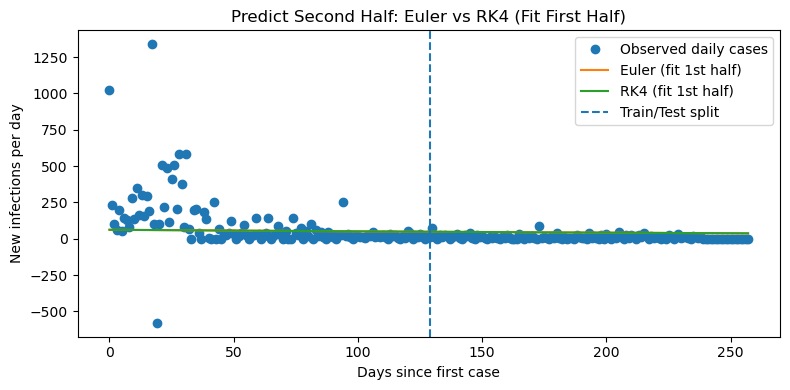

In [29]:
plt.figure(figsize=(8,4))
plt.plot(t_obs, I_obs, "o", label="Observed daily cases")
plt.plot(t_obs, inc_pred_full_euler, label="Euler (fit 1st half)")
plt.plot(t_obs, inc_pred_full_rk, label="RK4 (fit 1st half)")
plt.axvline(t_obs[mid], linestyle="--", label="Train/Test split")
plt.xlabel("Days since first case")
plt.ylabel("New infections per day")
plt.title("Predict Second Half: Euler vs RK4 (Fit First Half)")
plt.legend()
plt.tight_layout()
plt.show()


## Data Analyis: 

### Methods

*IN A SUMMARY, DESCRIBE THE METHODS YOU USED TO ANALYZE AND MODEL THE DATA.*


### Analysis
*(Describe how you analyzed the data. This is where you should intersperse your Python code so that anyone reading this can run your code to perform the analysis that you did, generate your figures, etc.)*

In [21]:
## PYTHON CODE TO BUILD AND FIT AN SIR MODEL GOES HERE. INTERSPERSE COMMENTS (IN MARKDOWN) TO EXPLAIN EACH STEP.

## Verify and validate your analysis: 

Verification:
Verification confirmed that the SIR model and numerical methods were implemented correctly. Both the Euler and RK4 methods produced similar trajectories for suspected, infected, and recovered population, and the total population remained conserved. The parameter sensitivity matched with our theoretical expectations, where higher beta increased peak infections and higher gamma shortened outbreak duration. Grid searches consistently converged to similar beta and gamma values, and parameters fit using only the first half of the outbreak data accurately predicted the second half. This demonstrates that the numerical methods and procedure for fitting the parameters were reliable.

Validation: 
To validate our work, we compared the model outputs and fitted parameters to accurate Ebola epidemiology reported in the literature/provided data set. The fitted SIR model reproduced the overall shape and timing of the 2014 Sierra Leone outbreak, including a rapid rise in case and the following gradual decline. This was consistent with observed epidemic dynaics. The estimated recovery rate corresponds to an infectios period of about 1-2 weeks, which matches clinical observations of Ebola, and the implied transmission intensity aligns with reported reproduction numbers (RO ~ 1.5-2.5). This further supports our models plausibility, and these findings are consistent WHO reports on Ebola outbreak dynamics.

Source: https://www.who.int/news-room/fact-sheets/detail/ebola-disease

## Conclusions and ethical implications
Overall, the SIR model did a pretty good job in describing the general trend of the Ebola outbreak in Sierra Leone. The fitted beta and gamma values were extremely close whether the model was trained on the full dataset or only the first half, which suggests that the early outbreak data contained most of the information about how the disease was spreading. Euler’s method and the RK4 method also produced very similar results, showing that even simpler numerical methods can work reasonably well for this type of data. However, the model neglects to accounmt for real-world variability seen in the reported cases. Because of this, results from these types of models need to be interpreted carefully since they are more helpful for showing general trends than for giving exact predictions.

## Limitations and Future Work: 
One limitation of this analysis is that both Euler’s method and RK4 are solving the same simplified SIR model. While RK4 is more numerically accurate than Euler, it doesn’t fix the assumptions built into the model itself. In both cases, the model assumes constant transmission and recovery rates and doesn’t account for changes in behavior, interventions, or reporting over time. Because of this, both methods smooth out a lot of the variation in the daily case data and miss sharp spikes or drops.
For future work, the focus should be on improving the overal model not just the numerical method. Allowing parameters like beta and gamma to change over time or using a model with more compartments could better reflect how the outbreak actually evolved. Trying different fitting approaches or accounting for noise in the data could also help improve how closely the model matches the reported cases.

## NOTES FROM YOUR TEAM: 
- 11/22 | Check-In 1: worked on project title & goal, researched disease background, loaded dataset, and applied code from canvas to begin analysis. Collaborated on topics required for the check-in, and communicated on how we wanted to edit the provided code from lecture for our project. 
-12/16 Finalized project, uploaded to GitHub repositories.

## QUESTIONS FOR YOUR TA: 
- 11/22 | No questions at this time.
- 12/16 | No questions.